In [1]:
!nvidia-smi

Sat May 14 13:25:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Dataset Download

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d yagtapandeya/cat-sound-classification-dataset

  0% 0.00/5.17M [00:00<?, ?B/s]
100% 5.17M/5.17M [00:00<00:00, 68.2MB/s]


In [6]:
!unzip *.zip && rm -rf *.zip

Archive:  cat-sound-classification-dataset.zip
  inflating: CAT_DB/Angry/car_extcoll0156.mp3  
  inflating: CAT_DB/Angry/car_extcoll0162.mp3  
  inflating: CAT_DB/Angry/car_extcoll0169.mp3  
  inflating: CAT_DB/Angry/car_extcoll0171.mp3  
  inflating: CAT_DB/Angry/car_extcoll0172.mp3  
  inflating: CAT_DB/Angry/car_extcoll0174.mp3  
  inflating: CAT_DB/Angry/car_extcoll0175.mp3  
  inflating: CAT_DB/Angry/car_extcoll0177.mp3  
  inflating: CAT_DB/Angry/car_extcoll0191.mp3  
  inflating: CAT_DB/Angry/car_extcoll0212.mp3  
  inflating: CAT_DB/Defense/car_extcoll0168.mp3  
  inflating: CAT_DB/Defense/car_extcoll0180.mp3  
  inflating: CAT_DB/Defense/car_extcoll0181.mp3  
  inflating: CAT_DB/Defense/car_extcoll0235.mp3  
  inflating: CAT_DB/Defense/car_extcoll0236.mp3  
  inflating: CAT_DB/Defense/car_extcoll0251.mp3  
  inflating: CAT_DB/Defense/car_extcoll0255.mp3  
  inflating: CAT_DB/Defense/car_extcoll0259.mp3  
  inflating: CAT_DB/Defense/car_extcoll0263.mp3  
  inflating: CAT_DB/Def

#Libraries

In [7]:
!pip install tensorflow-io

     |████████████████████████████████| 23.4 MB 2.4 MB/s 


In [67]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

# MP3 to WAV

In [9]:
!sudo apt-get install -y python-pydub
!pip install pydub

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  python-pydub
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 22.3 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydub all 0.20.0-1 [22.3 kB]
Fetched 22.3 kB in 0s (57.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling b

In [10]:
from pydub import AudioSegment

In [11]:
def convert_mp3_to_wav(filename, save_path):
  input_file = filename
  output_file = filename.split("/")[-1].split(".")[0]+".wav"
  
  output_path = os.path.join(save_path, output_file)
  # convert mp3 file to wav file
  sound = AudioSegment.from_mp3(input_file)
  sound.export(output_path, format="wav")

In [12]:
main_directory = "processed"

if not os.path.exists("/content/processed"):
  os.mkdir("/content/"+main_directory)

for directory in os.listdir("/content/CAT_DB/"):
  path = "/content/"+main_directory+"/"+directory
  if not os.path.exists(path):
    os.mkdir(path)

In [13]:
in_path = "/content/CAT_DB/"
out_path = "/content/processed/"

for directory in os.listdir(in_path):
  dir = os.path.join(in_path, directory)
  for file in os.listdir(dir):
    filename = os.path.join(dir, file)
    save_path = os.path.join(out_path, directory)
    convert_mp3_to_wav(filename, save_path)
    print(f"Processed: {save_path}")

Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Warning
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Happy
Processed: /content/processed/Paining
Processed: /content/processed/Paining
Processed: /content/processed/Paining
Processed: /content/processed/Paining
Processed: /content/processed/Paining
Processed: /content/processed/Paining
Processed: /content/processed/Pa

#Audio Loader

In [14]:
def load_wav_16k_mono(filename):
  # load encoded mp3 file
  file_contents = tf.io.read_file(filename)
  # Decode mp3 (tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # remove axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # convert from 44100Hz to 16000Hz
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

#Plots or Visualizing

In [15]:
angry = load_wav_16k_mono("/content/processed/Angry/car_extcoll0156.wav")
defense = load_wav_16k_mono("/content/processed/Defense/car_extcoll0180.wav")
fighting = load_wav_16k_mono("/content/processed/Fighting/car_extcoll0218.wav")
happy = load_wav_16k_mono("/content/processed/Happy/cat_53.wav")
hunting = load_wav_16k_mono("/content/processed/HuntingMind/car_extcoll0327.wav")

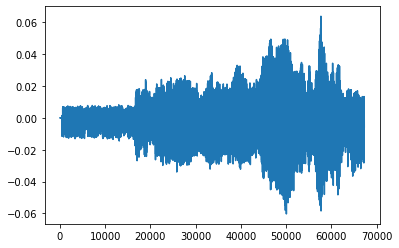

In [16]:
plt.plot(angry)
plt.show()

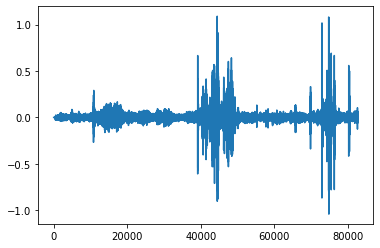

In [17]:
plt.plot(defense)
plt.show()

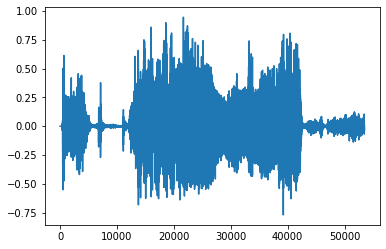

In [18]:
plt.plot(fighting)
plt.show()

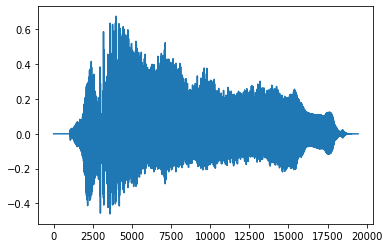

In [19]:
plt.plot(happy)
plt.show()

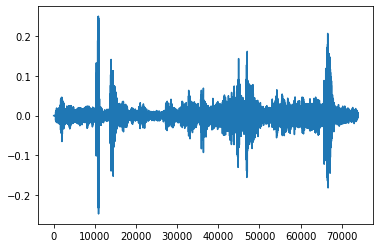

In [20]:
plt.plot(hunting)
plt.show()

#Data Loading and Preparing

In [21]:
ANGRY = os.path.join("/content/processed", "Angry")
DEFENSE = os.path.join("/content/processed", "Defense")
HAPPY = os.path.join("/content/processed", "Happy")
FIGHTING = os.path.join("/content/processed", "Fighting")
HUNTINGMIND = os.path.join("/content/processed", "HuntingMind")
MATING = os.path.join("/content/processed", "Mating")
MOTHERCALL = os.path.join("/content/processed", "MotherCall")
PAINING = os.path.join("/content/processed", "Paining")
RESTING = os.path.join("/content/processed", "Resting")
WARNING = os.path.join("/content/processed", "Warning")

In [22]:
angry_files = tf.data.Dataset.list_files(ANGRY+'/*.wav')
defense_files = tf.data.Dataset.list_files(DEFENSE+'/*.wav')
happy_files = tf.data.Dataset.list_files(HAPPY+'/*.wav')
fighting_files = tf.data.Dataset.list_files(FIGHTING+'/*.wav')
huntingmind_files = tf.data.Dataset.list_files(HUNTINGMIND+'/*.wav')
mating_files = tf.data.Dataset.list_files(MATING+'/*.wav')
mothercall_files = tf.data.Dataset.list_files(MOTHERCALL+'/*.wav')
paining_files = tf.data.Dataset.list_files(PAINING+'/*.wav')
resting_files = tf.data.Dataset.list_files(RESTING+'/*.wav')
warning_files = tf.data.Dataset.list_files(WARNING+'/*.wav')

In [23]:
# adding labels and concatenating all data
labels = ["Angry", "Defense", "Happy", "Fighting", "HuntingMind"
        , "Mating", "MotherCall", "Paining", "Resting", "Warning"]
ys_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xs_labels = tf.keras.utils.to_categorical(ys_labels)
xs_labels

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [24]:
angry_loader = tf.data.Dataset.zip((angry_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[0] for _ in range(len(angry_files))]))))
defense_loader = tf.data.Dataset.zip((defense_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[1] for _ in range(len(defense_files))]))))
happy_loader = tf.data.Dataset.zip((happy_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[2] for _ in range(len(happy_files))]))))
fighting_loader = tf.data.Dataset.zip((fighting_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[3] for _ in range(len(fighting_files))]))))
hunting_loader = tf.data.Dataset.zip((huntingmind_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[4] for _ in range(len(huntingmind_files))]))))
mating_loader = tf.data.Dataset.zip((mating_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[5] for _ in range(len(mating_files))]))))
mother_loader = tf.data.Dataset.zip((mothercall_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[6] for _ in range(len(mothercall_files))]))))
paining_loader = tf.data.Dataset.zip((paining_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[7] for _ in range(len(paining_files))]))))
resting_loader = tf.data.Dataset.zip((resting_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[8] for _ in range(len(resting_files))]))))
warning_loader = tf.data.Dataset.zip((warning_files, tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([xs_labels[9] for _ in range(len(warning_files))]))))

In [25]:
!nvidia-smi

Sat May 14 13:28:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    58W / 149W |    151MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Calculate Wave Cycle Length

In [26]:
lengths = []

in_path = "/content/processed/"

for directory in os.listdir(in_path):
  dir = os.path.join(in_path, directory)
  for file in os.listdir(dir):
    filename = os.path.join(dir, file)
    tensor_wave = load_wav_16k_mono(filename)
    lengths.append(len(tensor_wave))

In [27]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=57144>

In [28]:
57144/16000

3.5715

In [29]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=16108>

In [30]:
16100/16000

1.00625

In [31]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=135836>

In [32]:
135836/16000

8.48975

In [33]:
49000/16000

3.0625

#Preprocessing Function

In [34]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:49000]
  zero_padding = tf.zeros([49000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=-1)
  return spectrogram, label

#Spectrograms

Shape is: (1522, 257, 1)
Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


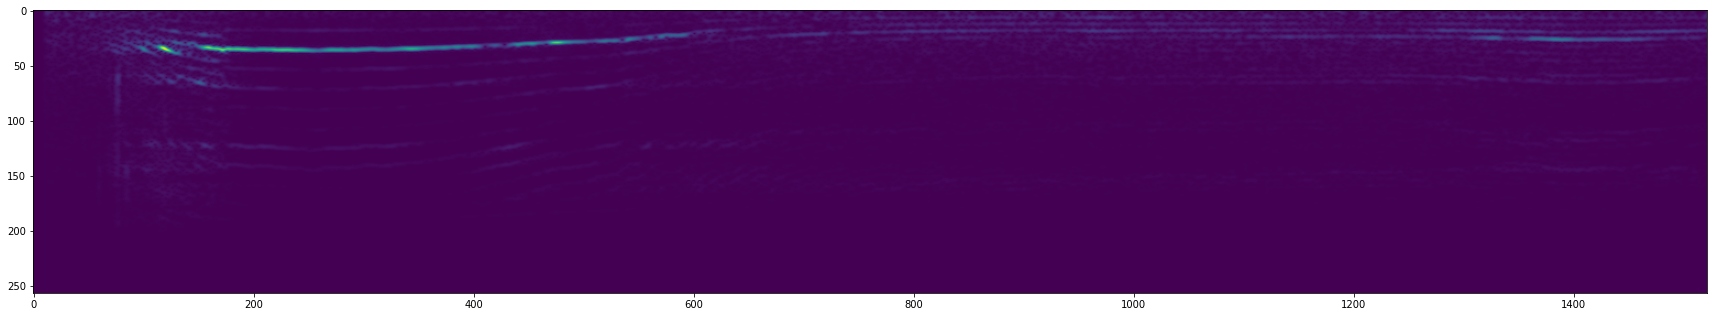

In [35]:
filepath_angry, label = angry_loader.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath_angry, label)
print(f"Shape is: {spectrogram.shape}")
print(f"Label: {label}")
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Shape is: (1522, 257, 1)
Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


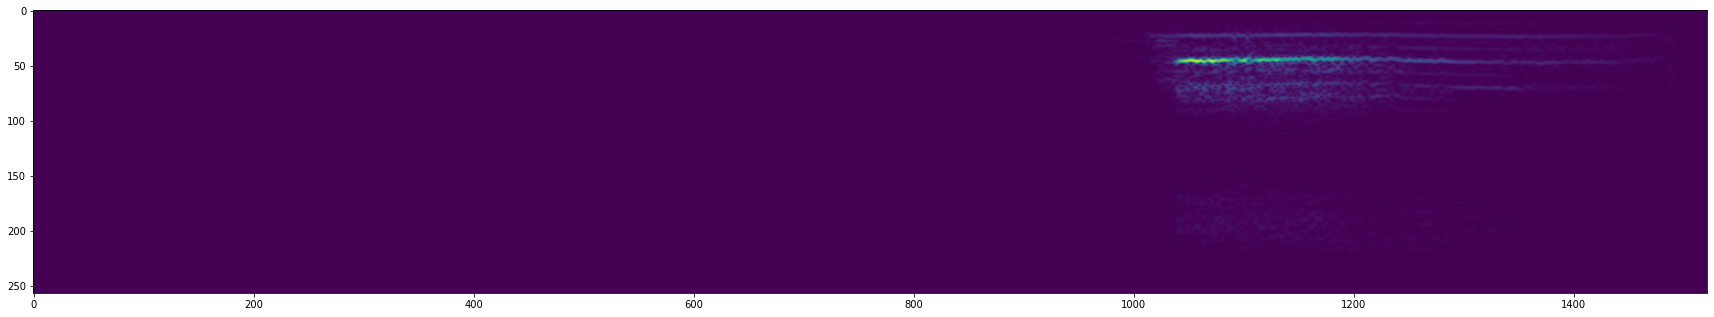

In [36]:
filepath_happy, label = happy_loader.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath_happy, label)
print(f"Shape is: {spectrogram.shape}")
print(f"Label: {label}")
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Shape is: (1522, 257, 1)
Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


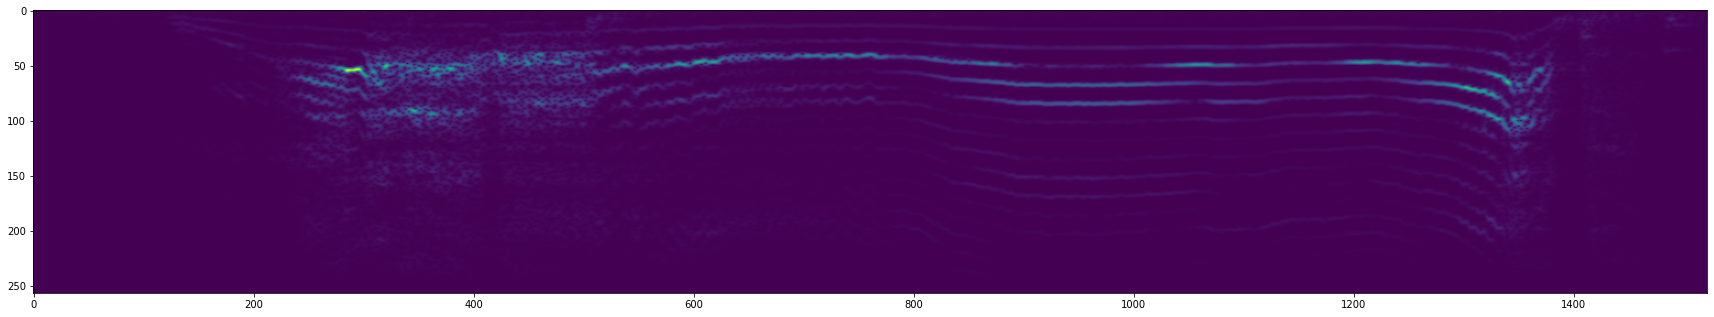

In [37]:
filepath_fighting, label = fighting_loader.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath_fighting, label)
print(f"Shape is: {spectrogram.shape}")
print(f"Label: {label}")
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

#Data Pipelines

In [38]:
dataset = angry_loader.concatenate(defense_loader)
dataset = dataset.concatenate(happy_loader)
dataset = dataset.concatenate(fighting_loader)
dataset = dataset.concatenate(hunting_loader)
dataset = dataset.concatenate(mating_loader)
dataset = dataset.concatenate(mother_loader)
dataset = dataset.concatenate(paining_loader)
dataset = dataset.concatenate(resting_loader)
dataset = dataset.concatenate(warning_loader)

dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(8)
dataset = dataset.prefetch(2)

In [39]:
len(dataset)*.7

9.1

In [40]:
len(dataset)*.3

3.9

In [41]:
train = dataset.take(9)
test = dataset.skip(9).take(4)

In [ ]:
samples, labels = test.as_numpy_iterator().next()
samples.shape

(8, 1522, 257, 1)

#Deep Learning Model

In [42]:
!nvidia-smi

Sat May 14 13:28:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    58W / 149W |    186MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(1522, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 1520, 255, 16)     160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 760, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 758, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 379, 62, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 377, 60, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 188, 30, 64)     

In [52]:
model.compile(
    optimizer="Adam",
    loss="CategoricalCrossentropy",
    metrics=[
             tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision()
    ]
)

In [53]:
history = model.fit(train, epochs=50, validation_data=test)

Epoch 1/50
9/9 [==============================] - 6s 336ms/step - loss: 6.5413 - recall_1: 0.1250 - precision_1: 0.2432 - val_loss: 2.2031 - val_recall_1: 0.0714 - val_precision_1: 0.2857
Epoch 2/50
9/9 [==============================] - 2s 213ms/step - loss: 1.8122 - recall_1: 0.0972 - precision_1: 0.5833 - val_loss: 1.2366 - val_recall_1: 0.3571 - val_precision_1: 0.8333
Epoch 3/50
9/9 [==============================] - 2s 206ms/step - loss: 1.1201 - recall_1: 0.4028 - precision_1: 0.8788 - val_loss: 0.9025 - val_recall_1: 0.5357 - val_precision_1: 0.8824
Epoch 4/50
9/9 [==============================] - 2s 203ms/step - loss: 0.8176 - recall_1: 0.5417 - precision_1: 0.9286 - val_loss: 0.7012 - val_recall_1: 0.5714 - val_precision_1: 0.8889
Epoch 5/50
9/9 [==============================] - 2s 175ms/step - loss: 0.8153 - recall_1: 0.7083 - precision_1: 0.9444 - val_loss: 0.4875 - val_recall_1: 0.7857 - val_precision_1: 1.0000
Epoch 6/50
9/9 [==============================] - 2s 175ms/s

#Model Plots

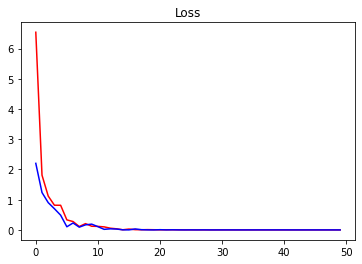

In [54]:
plt.title("Loss")
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

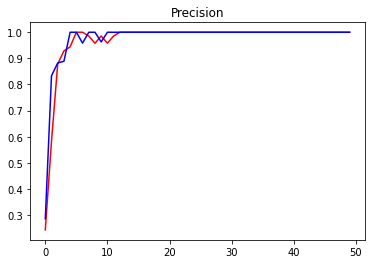

In [56]:
plt.title("Precision")
plt.plot(history.history['precision_1'], 'r')
plt.plot(history.history['val_precision_1'], 'b')
plt.show()

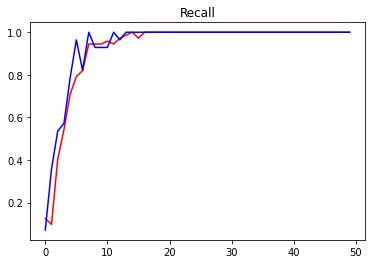

In [57]:
plt.title("Recall")
plt.plot(history.history['recall_1'], 'r')
plt.plot(history.history['val_recall_1'], 'b')
plt.show()

#Evaluation

In [58]:
x_test, y_test = test.as_numpy_iterator().next()

In [59]:
x_test.shape

(8, 1522, 257, 1)

In [60]:
y_test.shape

(8, 10)

In [61]:
y_hat = model.predict(x_test)

In [69]:
for i in range(len(y_hat)):
  print(f"Actual: {np.argmax(y_test[i])} and Prediction: {np.argmax(y_hat[i])}")

Actual: 5 and Prediction: 5
Actual: 7 and Prediction: 7
Actual: 9 and Prediction: 9
Actual: 9 and Prediction: 9
Actual: 1 and Prediction: 1
Actual: 2 and Prediction: 2
Actual: 4 and Prediction: 4
Actual: 1 and Prediction: 1


In [66]:
y_test

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [70]:
y_hat

array([[8.6108353e-14, 1.4905008e-16, 1.8015679e-15, 8.1918856e-18,
        6.9604636e-16, 1.0000000e+00, 1.7549610e-15, 1.0805864e-10,
        2.8926164e-13, 1.4923255e-18],
       [3.3036357e-28, 0.0000000e+00, 0.0000000e+00, 9.8137777e-29,
        1.9075897e-36, 0.0000000e+00, 9.2465965e-13, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9127452e-17, 5.9193383e-23, 4.5542649e-29, 3.9358900e-36,
        1.2225150e-27, 3.0095631e-38, 7.6331219e-31, 3.9080025e-36,
        1.1439878e-25, 1.0000000e+00],
       [1.2571909e-04, 6.7085644e-08, 5.6505974e-07, 2.4572429e-08,
        1.3942961e-04, 1.4895921e-04, 5.0563381e-06, 1.4940813e-09,
        1.3304518e-04, 9.9944705e-01],
       [2.3641901e-15, 1.0000000e+00, 1.9285846e-18, 1.9642247e-13,
        5.4843284e-19, 4.6354669e-23, 6.8120474e-24, 5.8933788e-13,
        1.8888943e-27, 2.7228142e-17],
       [6.9838625e-14, 2.3741079e-27, 1.0000000e+00, 3.3048921e-23,
        2.2845780e-19, 3.0382574e-19, 1.0882411e-18, 7.16

# Loading MP3's and Predicting window by window

In [71]:
def load_mp3_16k_mono(filename):
  # Loading as tensor
  res = tfio.audio.AudioIOTensor(filename)
  # Convert to Tensor and COnvert from Stereo to Mono means 2 channels to one channel audio
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1) / 2
  # Getting Sample rate
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Resampling to 16000Hx
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
  return wav

In [72]:
wav = load_mp3_16k_mono("/content/CAT_DB/Angry/car_extcoll0177.mp3")

In [74]:
wav

<tf.Tensor: shape=(112431,), dtype=float32, numpy=
array([ 0.0000000e+00,  1.8090049e-15,  3.7953691e-15, ...,
       -3.8698617e-02, -2.0676691e-02, -1.6221019e-02], dtype=float32)>

In [83]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([49000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=-1)
  return spectrogram

In [84]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=49000, sequence_stride=49000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [85]:
yhat_mp3 = model.predict(audio_slices)

In [86]:
yhat_mp3

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [87]:
model.save("cat_sound_model.h5")

#Implemented By Muhammad Hanan Asghar